In [242]:
import cmdstanpy
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [243]:
from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

# Problem statement 

In the project we modeled the relationship between the amount of sugar and calories in cereals.

Dataset was collected from https://www.kaggle.com/datasets/crawford/80-cereals?select=cereal.csv.
<br>It contains nutrition values (like protein, fat, sugars and much more) of 77 different types of cereals.

# Data preprocessing

In [244]:
df = pd.read_csv('cereal.csv', index_col=0)

In [245]:
df.head()

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating;;
100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973;;
100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679;;
All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505;;
All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912;;
Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843;;


Those nutrition values are defined as per serving where serving size is gien in 'weight' table in ounces. So we decided to scale it to have values for 1 ounce in every row.

In [246]:
df['sugars'] = df['sugars']/df['weight']
df['calories'] = df['calories']/df['weight']

In [247]:
df.head()

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating;;
100% Bran,N,C,70.0,4,1,130,10.0,5.0,6.0,280,25,3,1.0,0.33,68.402973;;
100% Natural Bran,Q,C,120.0,3,5,15,2.0,8.0,8.0,135,0,3,1.0,1.00,33.983679;;
All-Bran,K,C,70.0,4,1,260,9.0,7.0,5.0,320,25,3,1.0,0.33,59.425505;;
All-Bran with Extra Fiber,K,C,50.0,4,0,140,14.0,8.0,0.0,330,25,3,1.0,0.50,93.704912;;
Almond Delight,R,C,110.0,2,2,200,1.0,14.0,8.0,-1,25,3,1.0,0.75,34.384843;;


Histogram of calories

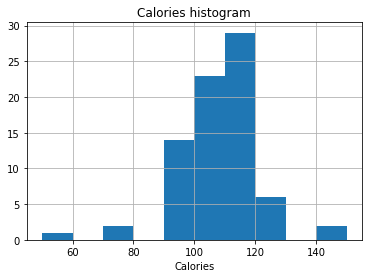

In [248]:
df['calories'].hist()
plt.title('Calories histogram')
plt.xlabel('Calories')
plt.show()

Histogram of sugars

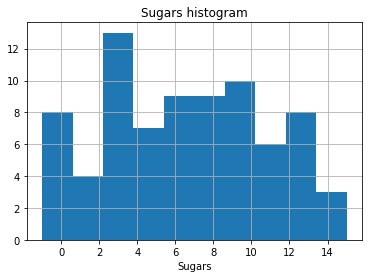

In [249]:
df['sugars'].hist()
plt.title('Sugars histogram')
plt.xlabel('Sugars')
plt.show()

Creation of dataframe with values that we need (calories and sugars).

In [250]:
data = df[['calories' ,'sugars']]

In [251]:
data

,calories,sugars
100% Bran,70.0,6.0
100% Natural Bran,120.0,8.0
All-Bran,70.0,5.0
All-Bran with Extra Fiber,50.0,0.0
Almond Delight,110.0,8.0
...,...,...
Triples,110.0,3.0
Trix,110.0,12.0
Wheat Chex,100.0,3.0
Wheaties,100.0,3.0


Next we've checked if all values are reasonable.

In [252]:
data['calories'].value_counts()

110.000000    29
100.000000    19
90.000000      7
120.000000     6
90.225564      3
70.000000      2
150.000000     2
50.000000      1
97.744361      1
96.000000      1
107.692308     1
106.666667     1
105.263158     1
104.000000     1
96.385542      1
93.333333      1
Name: calories, dtype: int64

In [253]:
data['sugars'].value_counts()

 3.000000     13
 0.000000      7
 6.000000      7
 8.000000      6
 5.000000      5
 11.000000     5
 12.000000     5
 7.000000      3
 10.000000     3
 13.000000     3
 2.000000      3
 9.000000      3
 9.022556      2
 15.000000     2
 1.000000      1
 6.015038      1
 14.000000     1
 4.000000      1
 6.923077      1
 8.666667      1
 5.263158      1
 10.526316     1
-1.000000      1
 9.333333      1
Name: sugars, dtype: int64

We've found that in sugars we have value of -1 which is an absurd. So we've decided to remove it.

In [254]:
data = data.drop(data[data['sugars'] == -1].index)

Dataframe statistics.

In [255]:
data.describe()

,calories,sugars
count,76.000000,76.000000
mean,104.049501,6.654904
std,13.936164,4.093540
min,50.000000,0.000000
25%,100.000000,3.000000
50%,107.179487,6.007519
75%,110.000000,10.000000
max,150.000000,15.000000


# Models in project

### 1. Model using normal distribution

#### 1.1 Model based only on calories
In our project we decided to start with simple model based only on calories.

#### 1.2 Model with sugars as predictor 
Next, we decided to add sugars as predictor. Calories will be now defined in the model as:
<br><br>
$calories_{i}\sim Normal(\mu _{i}, \sigma )$
<br><br>
$\mu _{i}=\alpha + \beta *sugars_{i}$
<br><br>
Where $\alpha$ and $\beta$ have normal distribution and $\sigma$ has exponential distribution.

### 2. Model using double exponential distribution
In the second model we decided to use double exponential distribution instead of normal distribution beacuse as we can se on calories histogram values of calories in our dataset are stacked in the middle of the histogram and we thought that it will fit our data better than normal distribution.
<br><br>
$calories_{i}\sim DoubleExponential(\mu _{i}, \sigma )$
<br><br>
$\mu _{i}=\alpha + \beta *sugars_{i}$
<br><br>
Where $\alpha$ and $\beta$ have normal distribution and $\sigma$ has exponential distribution.

<h1>1. Model using normal distribution</h1>

## 1.1
In the first model we've considered only calories and used normal distribution.

## Normal distribution

$$
Normal(y|\mu ,\sigma )=\frac{1}{\sqrt{2\pi}\sigma}exp\left ( -\frac{1}{2} \left ( \frac{y-\mu}{\sigma} \right )^{2} \right )
$$

## Prior predictive check

We set the value of mu to be normally distributed with mean of 104 and standard deviation of 14 because in our dataframe mean value of calories was 104.049501 and std was 13.936164.

The value of sigma was set to be exponentially distributed with inverse scale beta of 0.071 (because $\frac{1}{14}\approx 0.071$).

In [256]:
with open('cereal_1_ppc.stan') as file:
    print(file.read())

generated quantities {
   real mu = normal_rng(104, 14);
   real sigma = exponential_rng(0.071);
   real calories = normal_rng(mu, sigma);
}


In [257]:
model_ppc=cmdstanpy.CmdStanModel(stan_file='cereal_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [258]:
R = 1000
sim = model_ppc.sample(iter_sampling=R, iter_warmup=0, chains=1, fixed_param=True, seed=12062022, refresh=R, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [259]:
mu_sim=sim.stan_variable('mu')
sigma_sim=sim.stan_variable('sigma')
calories_sim=sim.stan_variable('calories')

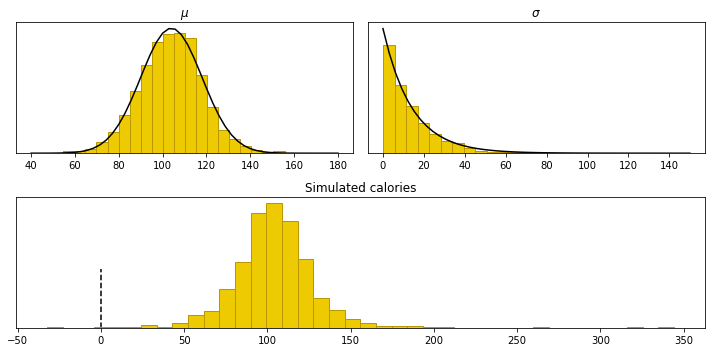

In [260]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[1,:])
ax1.vlines([0], ymin=0, ymax=1e-2, linestyle='--',color='black', zorder=1)
ax1.hist(calories_sim, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)

ax1.set_yticks([])
ax1.set_title('Simulated calories')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])

ax2.hist(mu_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(40,180)
y=stats.norm.pdf(x,loc=104,scale=14)
ax2.plot(x,y,'black')
ax3.set_title('$\sigma$')
ax2.set_title('$\mu$')
ax2.set_yticks([])
ax3.set_yticks([])
ax3.hist(sigma_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,150)
y=stats.expon.pdf(x,scale=14)
ax3.plot(x,y,'black')

fig.tight_layout()
plt.show()

As we can see simulated values of parameters $\mu$ and $\sigma$ were distributed well.
<br>Values of simulated calories are mostly distributed well (the mean is distributed were we expected) but we have some outliers which, when we add some data, will probably dissapear.

## Posterior analysis

In [261]:
with open('cereal_1_fit.stan') as file:
    print(file.read())

data {
   int N;
   real calories[N];
}

parameters {
   real mu;
   real<lower=0> sigma;
}

model {
   mu ~ normal(104, 14);
   sigma ~ exponential(0.071);
   calories ~ normal(mu, sigma);
}

generated quantities {
   real log_lik = normal_lpdf(calories | mu, sigma);
   real calorie = normal_rng(mu, sigma);
}


In [262]:
model_1_fit=cmdstanpy.CmdStanModel(stan_file='cereal_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [263]:
fit_1=model_1_fit.sample(data=dict(N=len(data['calories']), calories=data['calories'].values), seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [264]:
print(fit_1.diagnose())

Processing csv files: C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220613220811_1.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220613220811_2.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220613220811_3.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220613220811_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



No errors/issues occured during sampling.

In [265]:
az.summary(fit_1, var_names=['mu', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,104.00,1.63,101.01,107.05
sigma,14.07,1.15,11.94,16.20


In [266]:
mu_fit = fit_1.stan_variable('mu')
sigma_fit = fit_1.stan_variable('sigma')
calorie_pred = fit_1.stan_variable('calorie')

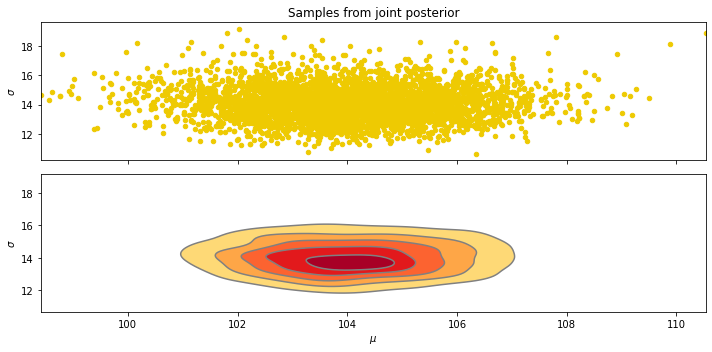

In [267]:
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True)
ax1=axes[0]
ax1.scatter(mu_fit, sigma_fit, 20, color=DARK)
ax1.set_title("Samples from joint posterior")
ax1.set_ylabel(r'$\sigma$')
ax2=axes[1]
az.plot_kde(mu_fit, sigma_fit, ax=ax2, contourf_kwargs={'cmap':'YlOrRd'})

ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$')
fig.tight_layout()
plt.show()

As we can see our sigma and mu samples from joint posterior are concenrated.

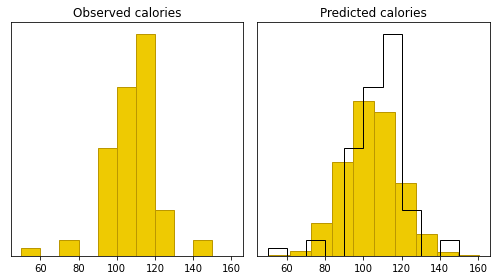

In [268]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(data['calories'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed calories')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred, bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(data['calories'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted calories')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

As we can see samples for posterior predictive did not match exactly the observed values. Observed values are more clustered close to the mean value.
<br>Data is not exactly similar with posterior predicitve sample but it's quite close.

<h1>1.2</h1>

We've decided to add predictor - value of sugars.
<br>Those values were centered to represent sugars not as grams but the difference from the mean. It was added to dataframe as 'c_sugars'.
<br><br>
$calories_{i}\sim Normal(\mu _{i}, \sigma )$
<br><br>
$\mu _{i}=\alpha + \beta *c\_sugars_{i}$
<br><br>
Where $\alpha$ and $\beta$ have normal distribution and $\sigma$ has exponential distribution.

<AxesSubplot:>

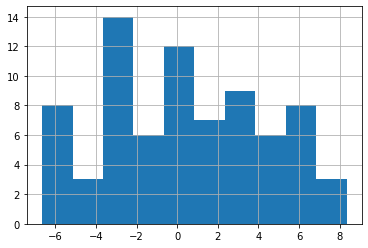

In [269]:
data['c_sugars'] = data['sugars']-data['sugars'].mean()
data['c_sugars'].hist()

## Prior predictive check

We used the same values for alpha and sigma as for mu and sigma in previous prior. The value of beta was set to be normally distriuted with mean of 0 and std of 10.

In [270]:
with open('cereal_2a_ppc.stan') as file:
    print(file.read())

data {
   int N;
   real sugars[N];
}

generated quantities {
   real alpha = normal_rng(104, 14);
   real beta = normal_rng(0, 10);
   real sigma = exponential_rng(0.071);
   real calorie[N];
   for (i in 1:N) {
      calorie[i] = normal_rng(sugars[i]*beta+alpha, sigma);
   }

}


In [271]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_2a_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [272]:
R = 1000
data_sim = {'N': len(data), 'sugars':np.linspace(data['c_sugars'].min(),data['c_sugars'].max(), num=len(data))}

sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [273]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

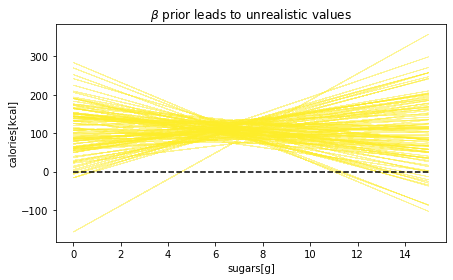

In [274]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(data['sugars'], alpha_sim[i]+beta_sim[i]*data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)
axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')
axes.set_title(r"$\beta$ prior leads to unrealistic values")
axes.hlines([0],xmin=data['sugars'].min(), xmax=data['sugars'].max(), linestyle='--', color='black')
plt.show()

In [275]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [276]:
sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [277]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

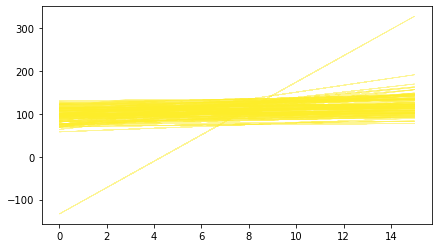

In [278]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(data['sugars'], alpha_sim[i]+beta_sim[i]*data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)

plt.show()

In [279]:
calorie_sim = sim.stan_variable('calorie')

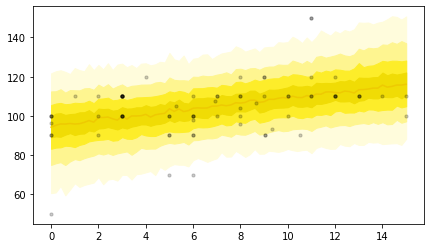

In [280]:
fig, axes = plt.subplots(1,1,figsize = (7,4))
axes=ribbon_plot(data_sim['sugars']+data['sugars'].mean(),calorie_sim,axes)
axes.scatter(data['sugars'], data['calories'], color = 'black', alpha = 0.2, s=10)
plt.show()

In [281]:
model_2_fit = cmdstanpy.CmdStanModel(stan_file='cereal_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [282]:
data_fit = dict(N=len(data),
                sugars=data['c_sugars'].values,
                calories=data['calories'].values)

fit_2=model_2_fit.sample(data=data_fit, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [290]:
alpha_fit = fit_2.stan_variable('alpha')
beta_fit = fit_2.stan_variable('beta')
mu_fit = fit_2.stan_variable('mu')
sigma_fit = fit_2.stan_variable('sigma')
calorie_pred = fit_2.stan_variable('calorie')

In [291]:
az.summary(fit_2, var_names=['alpha', 'beta', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,104.06,1.44,101.41,106.78
beta,1.16,0.37,0.45,1.84
sigma,13.13,1.11,11.08,15.20


In [306]:
# todo wykres dla alfa beta sigma ...

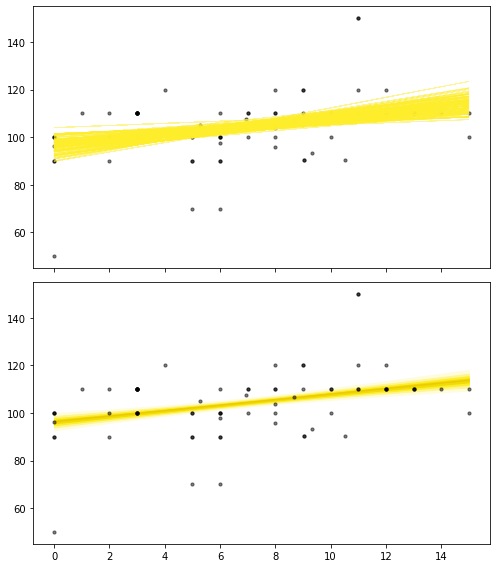

In [285]:
fig, axes = plt.subplots(2,1,figsize = (7,8), sharey=True, sharex=True)
ax0=axes[0]

for i in range(100):
    ax0.plot(data['sugars'],
            alpha_fit[i]+beta_fit[i]*data['c_sugars'],
            color=MID,
            alpha=0.5, linewidth=0.5)

ax0.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)

ax1=axes[1]
ax1=ribbon_plot(data['sugars'].values, mu_fit, ax1, supress_warning=True)
ax1.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)
fig.tight_layout()
plt.show()

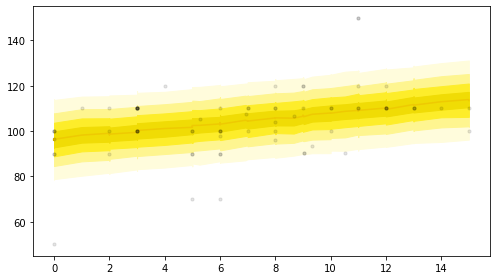

In [286]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

axes=ribbon_plot(data['sugars'].values, calorie_pred, axes, supress_warning=True)
axes.scatter(data['sugars'], data['calories'], color='black', alpha=0.1, s=10)
fig.tight_layout()
plt.show()

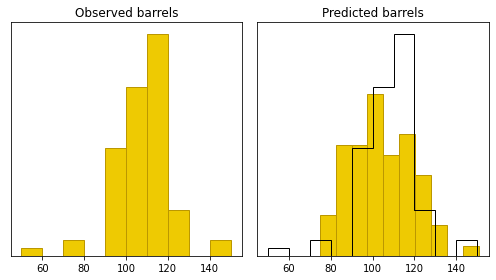

In [172]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(data['calories'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed barrels')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred[3213], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(data['calories'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted barrels')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

In [173]:
fit_id_2 = az.from_cmdstanpy(posterior=fit_2,log_likelihood='log_lik')

In [174]:
fit_id_2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

# Model 2

## Double Exponential (Laplace) Distribution
$$
DoubleExponential(y|\mu ,\sigma )=\frac{1}{2\sigma}exp\left ( -\frac{\left | y-\mu \right |}{\sigma} \right )
$$

# Prior predictive check

In [190]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_3_ppc.stan')

INFO:cmdstanpy:compiling stan file C:\GitHub\DataAnalyticsProject\Project\cereal_3_ppc.stan to exe file C:\GitHub\DataAnalyticsProject\Project\cereal_3_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\GitHub\DataAnalyticsProject\Project\cereal_3_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/GitHub/DataAnalyticsProject/Project/cereal_3_ppc.hpp C:/GitHub/DataAnalyticsProject/Project/cereal_3_ppc.stan
Warning in 'C:/GitHub/DataAnalyticsProject/Project/cereal_3_ppc.stan', line 3, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/GitHub/DataAnalyticsProject/Project/cereal_3_ppc.stan', line 10, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the arr

In [193]:
sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [213]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')
sigma_sim = sim.stan_variable('sigma')
calories_sim=sim.stan_variable('calorie')

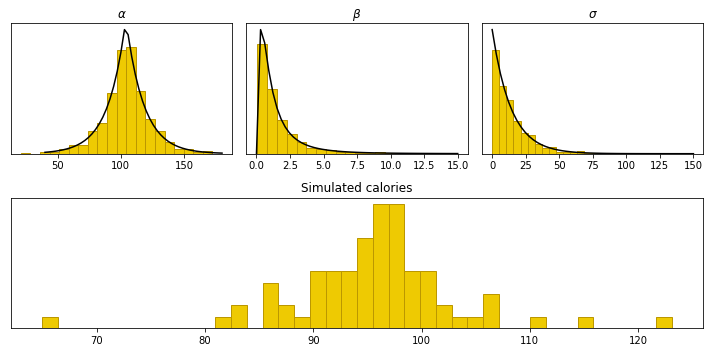

In [241]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[1,:])
ax1.hist(calories_sim[579], bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)

ax1.set_yticks([])
ax1.set_title('Simulated calories')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[0, 2])

ax2.hist(alpha_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(40,180)
y=stats.laplace.pdf(x,loc=104,scale=14)
ax2.plot(x,y,'black')
ax4.set_title('$\sigma$')
ax2.set_title(r'$\alpha$')
ax2.set_yticks([])
ax4.set_yticks([])
ax4.hist(sigma_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,150)
y=stats.expon.pdf(x,scale=14)
ax4.plot(x,y,'black')


ax3.hist(beta_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,15)
y=stats.lognorm.pdf(x, s=1)
ax3.plot(x,y,'black')
ax3.set_title(r'$\beta$')
ax3.set_yticks([])

fig.tight_layout()
plt.show()

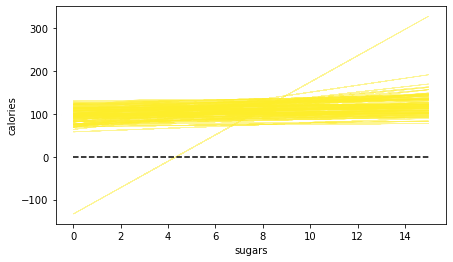

In [307]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(data['sugars'], alpha_sim[i]+beta_sim[i]*data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)
axes.set_xlabel('sugars')
axes.set_ylabel('calories')

axes.hlines([0],xmin=data['sugars'].min(), xmax=data['sugars'].max(), linestyle='--', color='black')
plt.show()

In [197]:
calorie_sim = sim.stan_variable('calorie')

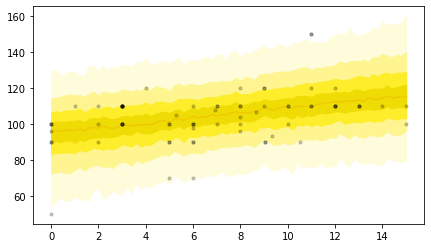

In [198]:
fig, axes = plt.subplots(1,1,figsize = (7,4))
axes=ribbon_plot(data_sim['sugars']+data['sugars'].mean(),calorie_sim,axes)
axes.scatter(data['sugars'], data['calories'], color = 'black', alpha = 0.2, s=10)
plt.show()

# Posterior

In [175]:
model_3_fit = cmdstanpy.CmdStanModel(stan_file='cereal_3_fit.stan')

INFO:cmdstanpy:compiling stan file C:\GitHub\DataAnalyticsProject\Project\cereal_3_fit.stan to exe file C:\GitHub\DataAnalyticsProject\Project\cereal_3_fit.exe
INFO:cmdstanpy:compiled model executable: C:\GitHub\DataAnalyticsProject\Project\cereal_3_fit.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/GitHub/DataAnalyticsProject/Project/cereal_3_fit.hpp C:/GitHub/DataAnalyticsProject/Project/cereal_3_fit.stan
Warning in 'C:/GitHub/DataAnalyticsProject/Project/cereal_3_fit.stan', line 4, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/GitHub/DataAnalyticsProject/Project/cereal_3_fit.stan', line 26, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the arr

In [178]:
data_fit = dict(N=len(data),
                sugars=data['c_sugars'].values,
                calories=data['calories'].values)

fit_3=model_3_fit.sample(data=data_fit, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [304]:
az.summary(fit_3, var_names=['alpha', 'beta', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,104.63,0.98,102.90,106.63
beta,0.91,0.19,0.54,1.26
sigma,8.72,1.02,6.74,10.53


In [305]:
# todo wykres dla alfa beta sigma ...

In [180]:
alpha_fit = fit_3.stan_variable('alpha')
beta_fit = fit_3.stan_variable('beta')
mu_fit = fit_3.stan_variable('mu')
calorie_pred = fit_3.stan_variable('calorie')

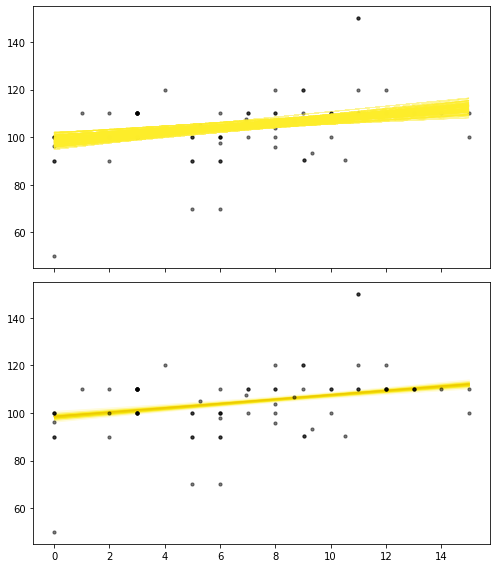

In [181]:
fig, axes = plt.subplots(2,1,figsize = (7,8), sharey=True, sharex=True)
ax0=axes[0]

for i in range(100):
    ax0.plot(data['sugars'],
            alpha_fit[i]+beta_fit[i]*data['c_sugars'],
            color=MID,
            alpha=0.5, linewidth=0.5)

ax0.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)

ax1=axes[1]
ax1=ribbon_plot(data['sugars'].values, mu_fit, ax1, supress_warning=True)
ax1.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)
fig.tight_layout()
plt.show()

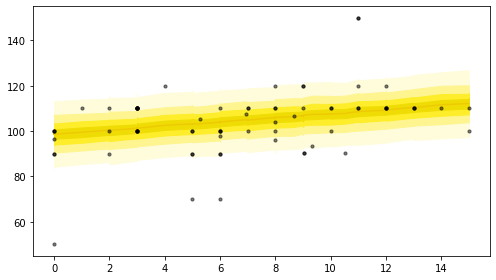

In [182]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

axes=ribbon_plot(data['sugars'].values, calorie_pred, axes, supress_warning=True)
axes.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)
fig.tight_layout()
plt.show()

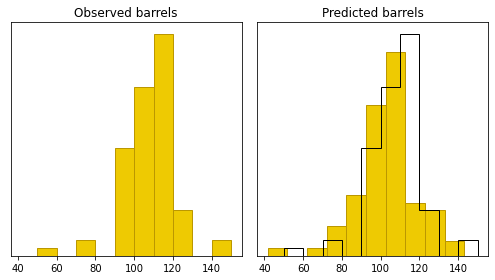

In [184]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(data['calories'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed barrels')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred[99], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(data['calories'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted barrels')
ax2.set_yticks(())
fig.tight_layout()

In [185]:
fit_id_3 = az.from_cmdstanpy(posterior=fit_3,log_likelihood='log_lik')

In [186]:
model_compare = az.compare({'Model 2':fit_id_2,'Model 3':fit_id_3})
model_compare

c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\Anaconda3\envs\data_analytics\lib\site-

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 3,0,-293.733139,2.620662,0.000000,1.0,9.984329,0.000000,False,log
Model 2,1,-305.792915,4.718237,12.059776,0.0,10.981114,3.801097,True,log


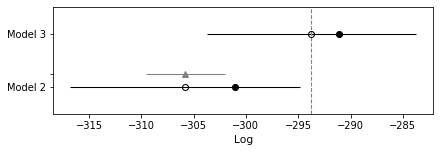

In [187]:
az.plot_compare(model_compare)
plt.show()

In [188]:
model_compare_2 = az.compare({'Model 2':fit_id_2,'Model 3':fit_id_3}, ic='waic')
model_compare_2

c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 3,0,-293.728342,2.615865,0.000000,1.000000e+00,9.983087,0.000000,False,log
Model 2,1,-305.661627,4.586949,11.933285,2.771117e-13,10.906193,3.743601,True,log


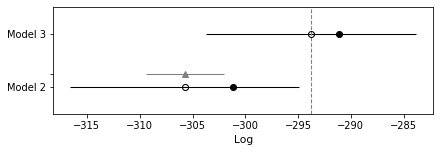

In [109]:
az.plot_compare(model_compare_2)
plt.show()